# Compact Proofs of Model Performance via Mechanistic Interpretability

## 0. Set up (Don't read)

In [1]:
%pip install tqdm
%pip install torch
%pip install einops
%pip install matplotlib
%pip install jaxtyping


[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
import torch as t
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import time
import einops
from torch.utils.data import Dataset, DataLoader
import random, numpy
from dataclasses import dataclass
from jaxtyping import Float, Int
from torch import Tensor
from typing import Optional, Callable, Union, List, Tuple
import copy
from tqdm import tqdm
from IPython.display import Image

In [7]:
@dataclass
class Parameters:
    n_ctx: int = 2
    d_vocab: int = 2048
    d_model: int = 128
    num_epoch: int = 2
    batch_size: int = 1024
    subset_percentage: float = 5
    lr: float = 0.001


params = Parameters()

In [8]:
def set_seed(seed: int = 57) -> None:
    numpy.random.seed(seed)
    random.seed(seed)
    t.manual_seed(seed)
    t.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)

In [9]:
def measure_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Function '{func.__name__}' executed in: {elapsed_time:.6f} seconds")
        return result, elapsed_time

    return wrapper

In [10]:
class TrainingDataMax(Dataset):
    def __init__(self, params):
        set_seed(57)
        self.n = params.d_vocab
        self.n_ctx = params.n_ctx

    def __getitem__(self, idx):

        inputs = [random.randint(0, self.n - 1) for i in range(self.n_ctx)]
        return inputs + [max(inputs)]

    def __len__(self):
        return self.n**self.n_ctx

In [12]:
def test_dataset(dataset):
    """
    Function to test a PyTorch Dataset.

    Parameters:
    - dataset (torch.utils.data.Dataset): The dataset to be tested.
    - batch_size (int): Number of samples per batch to load.
    - num_workers (int): How many subprocesses to use for data loading.

    Returns:
    None. Prints information about the batches.
    """

    print("Train data defined")
    dataloader = DataLoader(dataset=dataset, batch_size=params.batch_size, shuffle=True)
    print("Data loaded")

    print(f"Testing {dataset.__class__.__name__} with {len(dataset)} samples...")

    for i_batch, sample_batched in enumerate(dataloader):
        print(f"Batch {i_batch + 1}")

        # Print shapes or other relevant info about each element in sample_batched
        for x in sample_batched:
            print(x)

In [13]:
train_data = TrainingDataMax(params=Parameters)
# test_dataset(train_data)

## 1. Introduction

### 1.1 The problem of understanding a model

**Why do we care about about understanding a model?**

When we use or train a model, many things can go wrong. For example, during training the model can learn undesired behaviour, which is not obvious to us (deceptive alignment). Or it might have failure modes that are not salient to us (adversarial examples). 
On the other hand, we could steer a model towards a desired behaviour, if we understood how it works.

All of these issues could be resolved, if the models were transparent to us (though this is not the only approach). So an important question to raise here is: 
What do we mean when we talk of "a mechanistic understanding" of a model? When is a model transparent to us?

This is a difficult question! Let's say you study a model and reverse engineered parts of it, like a circuit. How can you be sure that the circuit you found actually does the thing you are claiming it is? Let's look at the specific example of autoencoders. This is a quote from [*Towards Monosemanticity: Decomposing Language Models With Dictionary Learning*](https://transformer-circuits.pub/2023/monosemantic-features)

>Usually in machine learning we can quite easily tell if a method is working by looking at an easily-measured quantity like the test loss. We spent quite some time searching for an equivalent metric to guide our efforts here, and unfortunately have yet to find anything satisfactory.
>
>We began by looking for an information-based metric, so that we could say in some sense that the best factorization is the one that minimizes the total information of the autoencoder and the data. Unfortunately, this total information did not generally correlate with subjective feature interpretability or activation sparsity.[...]
>
>Thus we ended up using a combination of several additional metrics to guide our investigations[...]
>
>Interpreting or measuring some of these signals can be difficult, though. For instance, at various points we thought we saw features which at first didn’t make any sense, but with deeper inspection we could understand.
>
>We think it would be very helpful if we could identify better metrics for dictionary learning solutions from sparse autoencoders trained on transformers.

See also Section 5 of this review [*Mechanistic Interpretability for AI Safety -- A Review*](https://arxiv.org/abs/2404.14082) for more references on the difficulty of evaluating interpretability results.

**Quantative methods for interpretability**

Having quantative methods would not only make mechanistic interpretability research more rigorous. If we want to scale up methods to huge models, we will need to automate parts of the process and we won't be able to have a human in the loop at every crucial point. A lack of quantative benchmarks makes this task seem almost impossible. To spoiler the punchline: Compact proofs provide such a quantative benchmark, although they currently are infeasible for larger models.

Before getting into the details, let's nail down two things that we want to quantify. The following two points are taken from the [Compact proofs blog post](https://www.alignmentforum.org/posts/bRsKimQcPTX3tNNJZ/compact-proofs-of-model-performance-via-mechanistic#Introduction), see also this [comment](https://www.lesswrong.com/posts/LNA8mubrByG7SFacm/against-almost-every-theory-of-impact-of-interpretability-1?commentId=7fNRMke9Gc4QghYyf) by Ryan Greenblatt.

>1. Correspondence (or faithfulness): How well our explanation reflects the model's internals.
>2. Compression: Explanations compress the particular behavior of interest. Not just so that it fits in our heads, but also so that it generalizes well and is feasible to find and check.

Specifically, the second points implies that the explanation, say the circuit that we discovered, should be more **compact** and therefore more understandable for us humans: The weights of a model are a perfectly faithful explanation of its behaviour, but this explanation is not helpful for us.

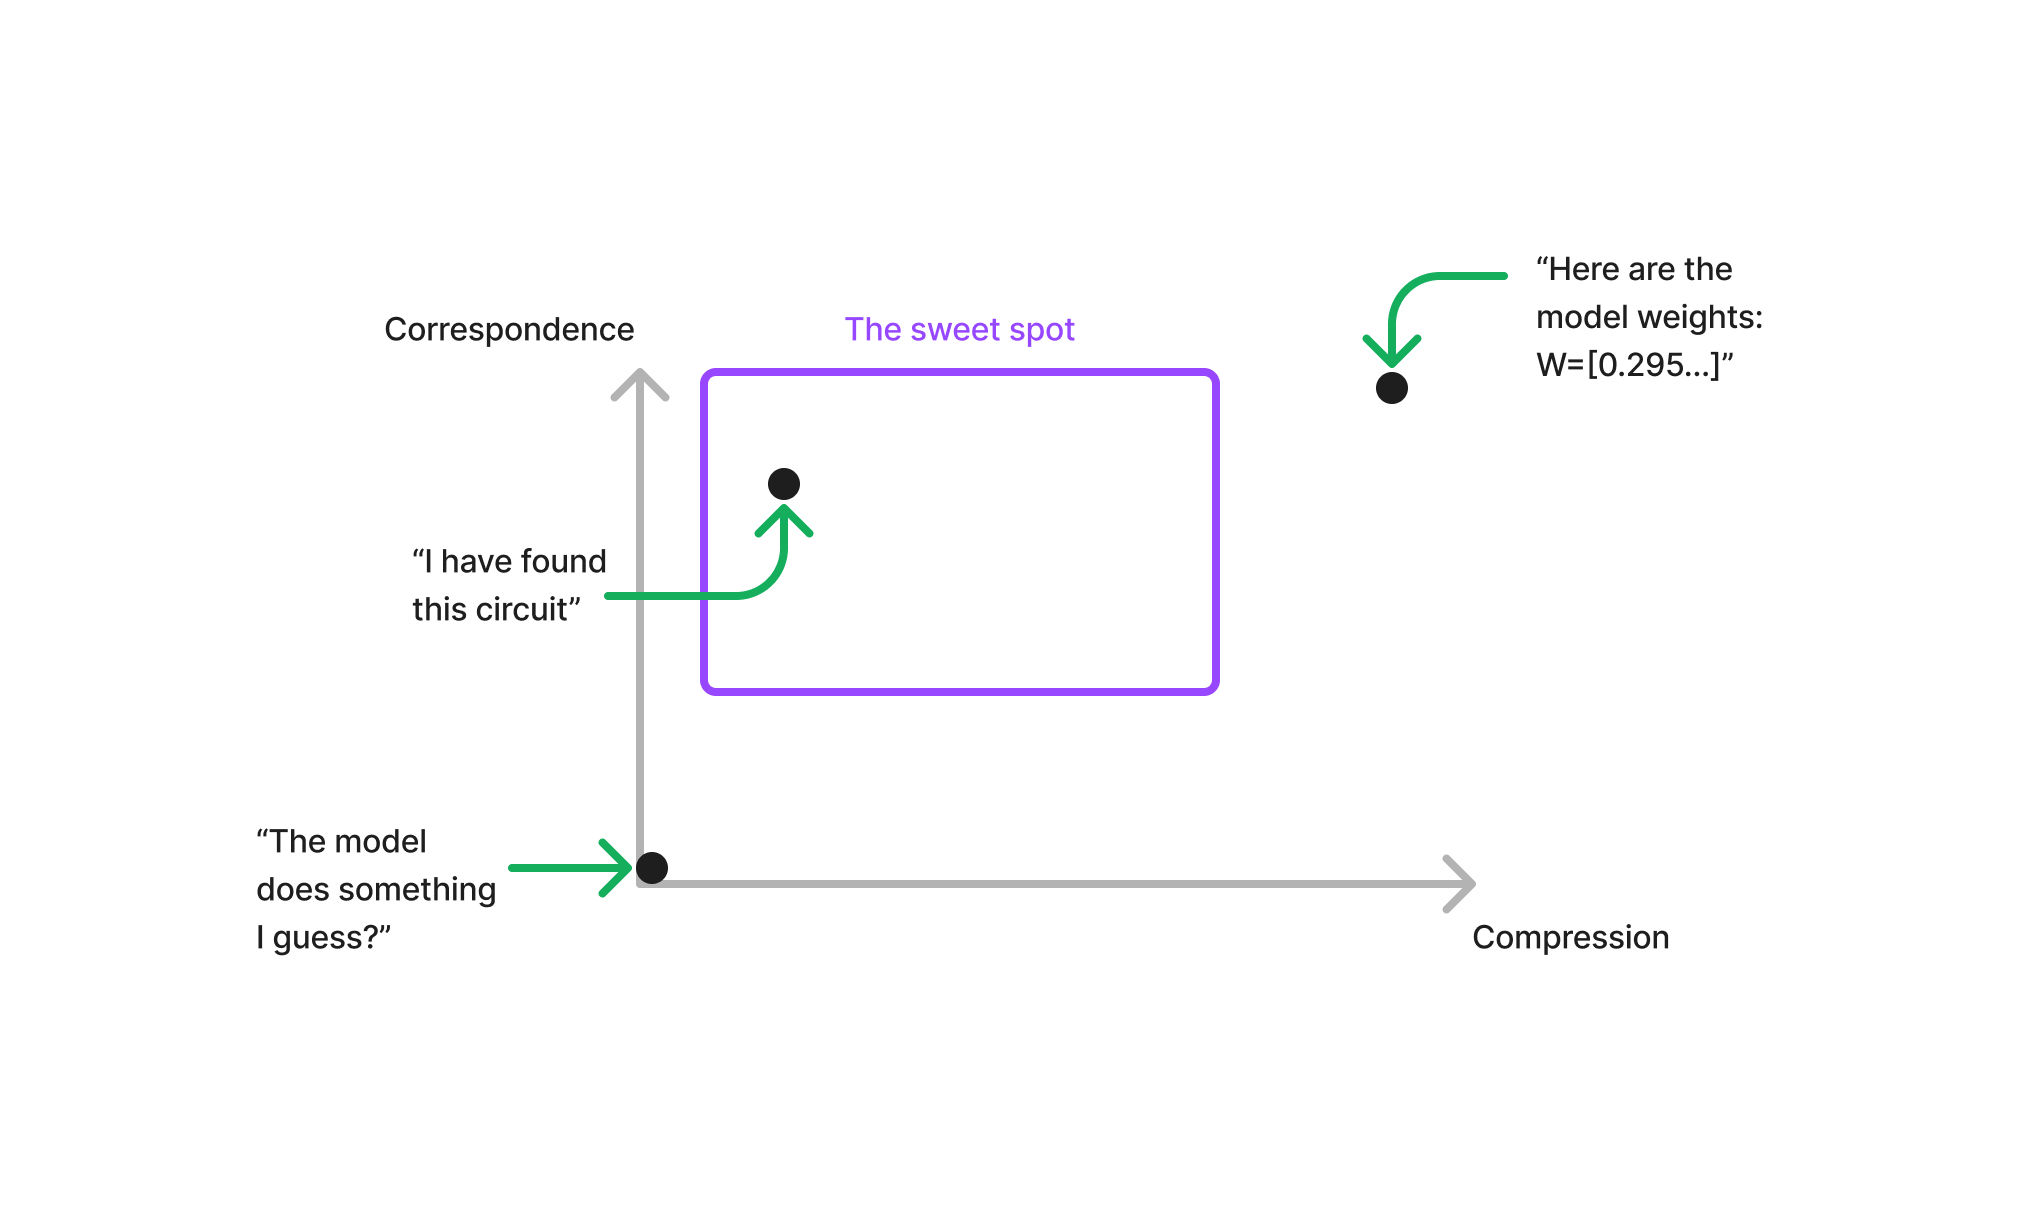

In [14]:
Image(filename="img/Compact proofs.png", width=800, height=400)
# Make this rather a pareto frontier?

An important insight that we will make is that our explanations are not as good as we might think. Specifically, **noise** in the model's weights seem negligible. But worst case bound imply that it could still be an important contribuiting factor. In fact, it might be that something that we deem as noise, is important for the model's computation, but we simply don't understand it. This issue with the noise is another point that a quantative evaluation should be able to address.

### 1.2 **What are compact proofs?**

- proofs of bounds
- graph of compact proofs
- this approach is hard but take away is not that proof approach is bad for quantification, but that quantification is hard.


## 2. Max-of-2 Example

Having worked through the very high level picture, let us now focus on the compact proofs approach and explain what it means. Let's say we have a model:

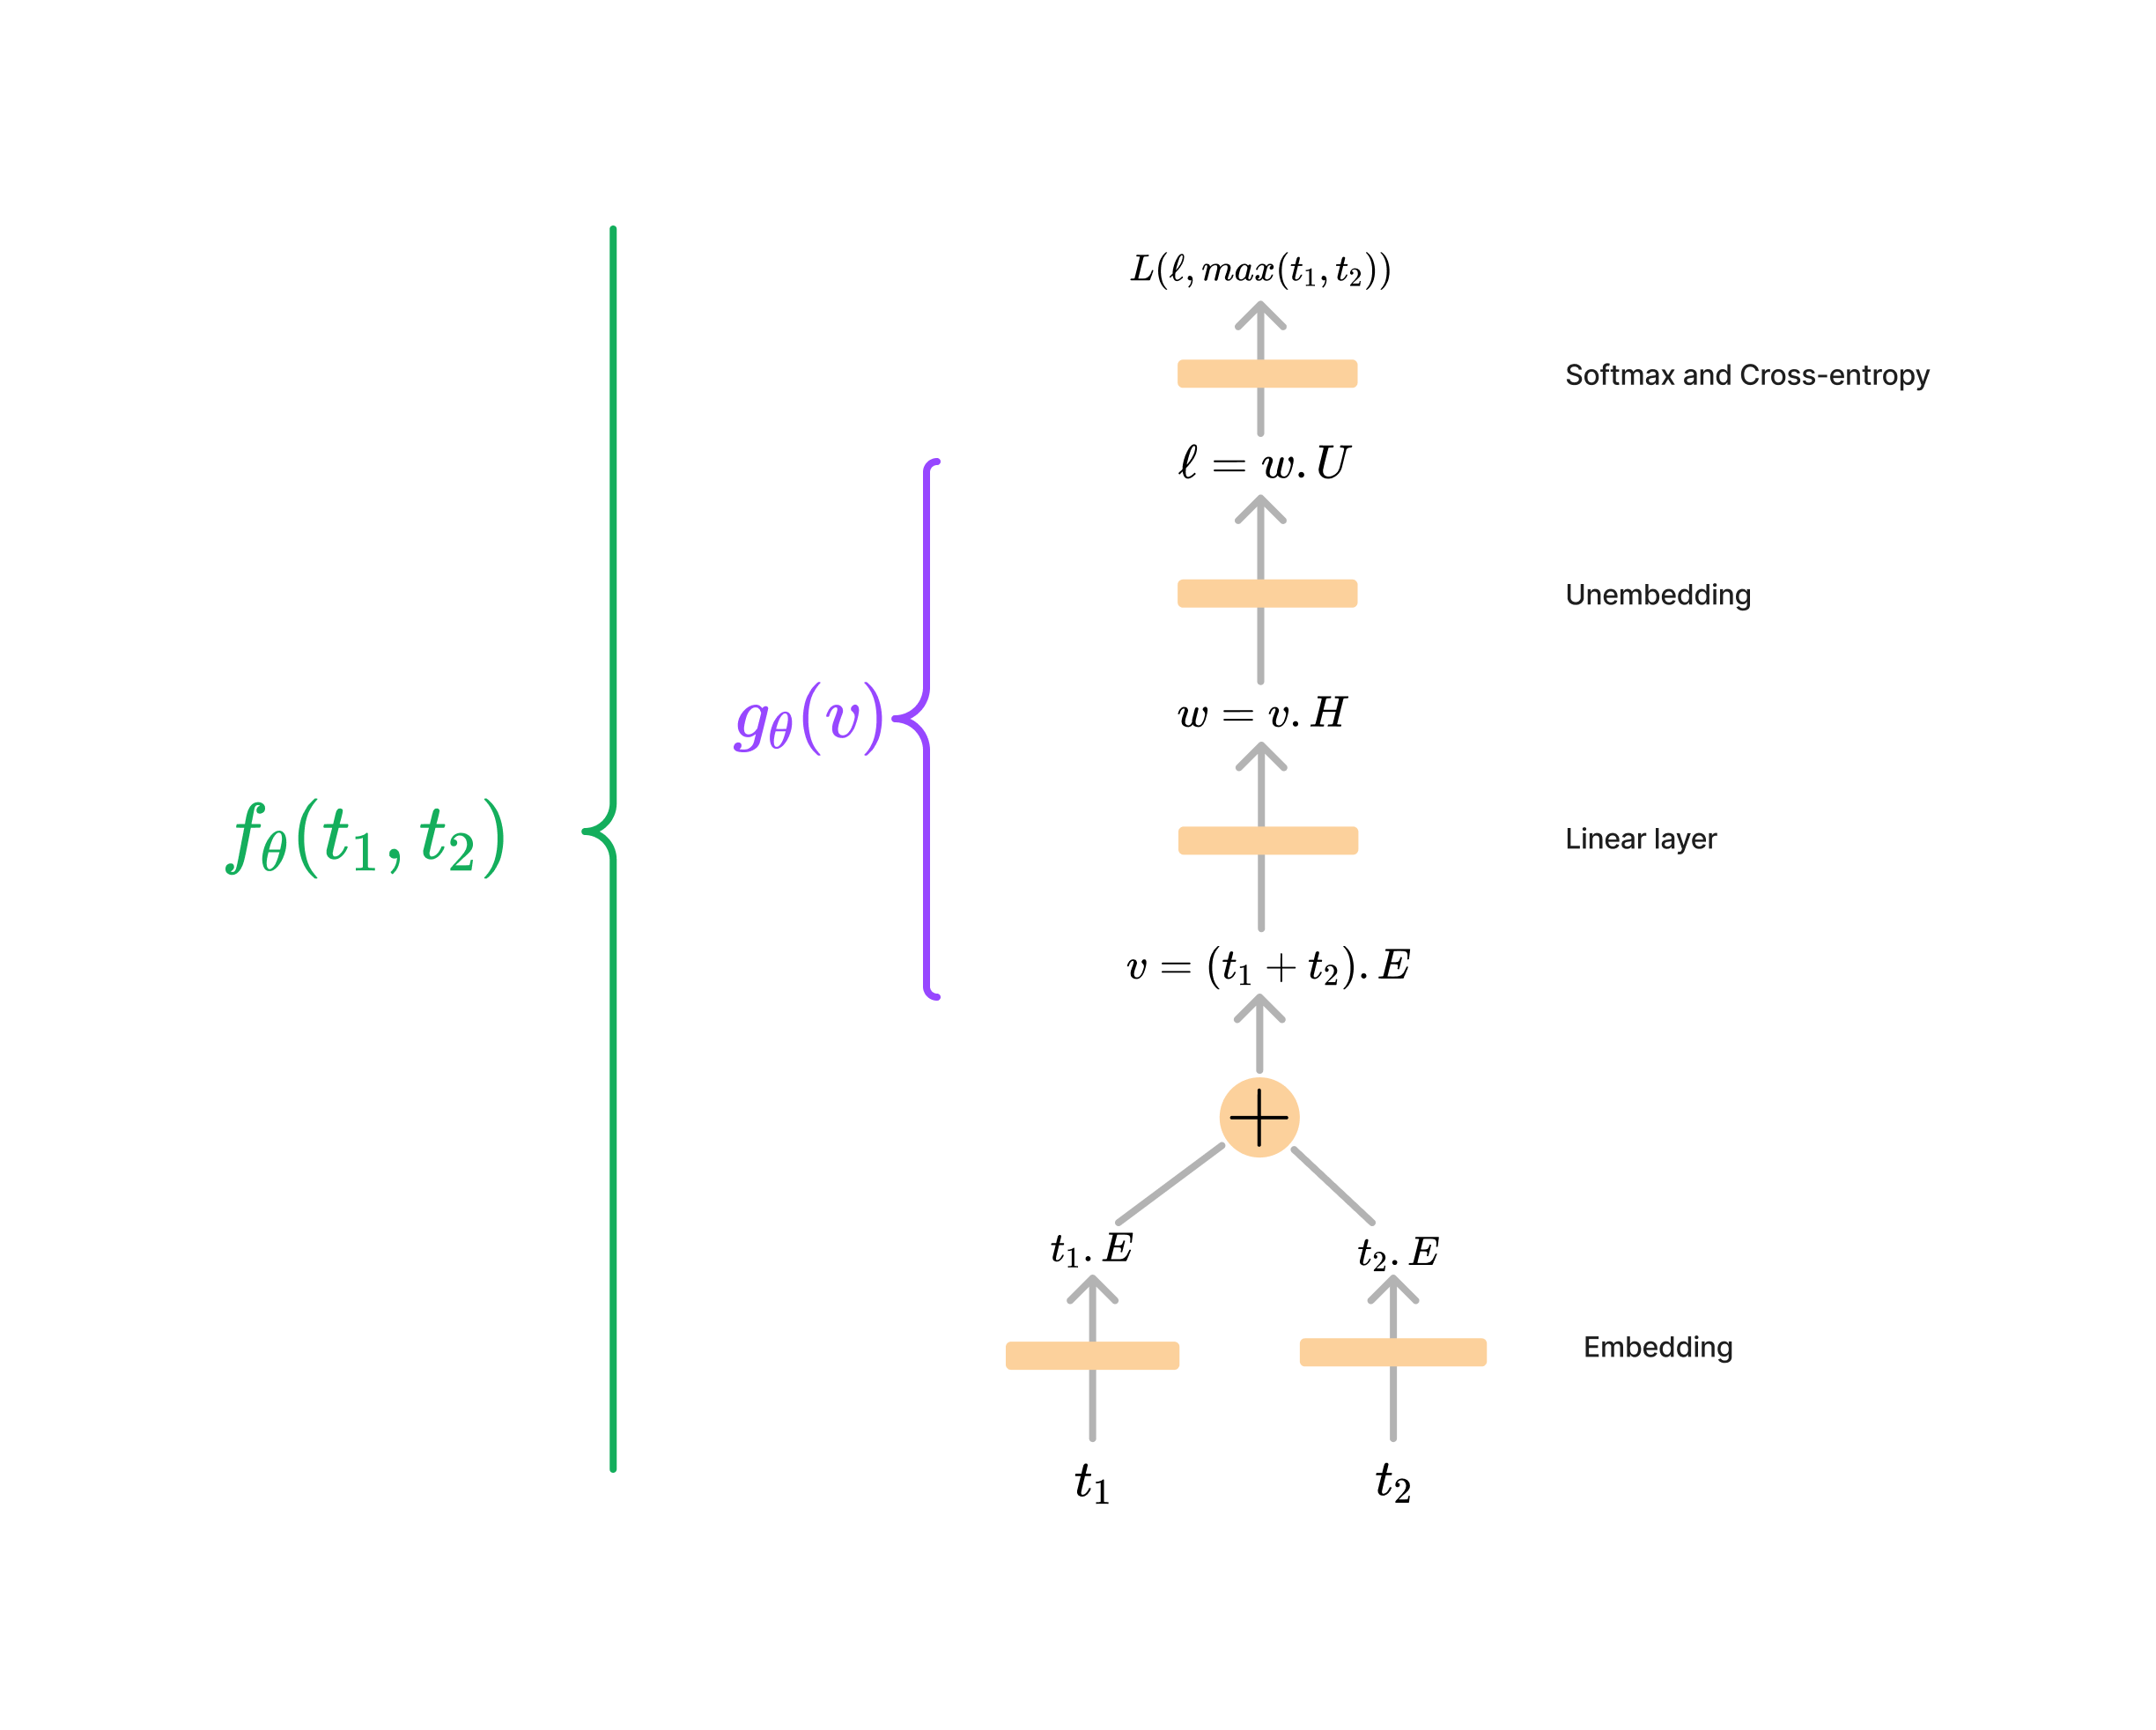

In [15]:
Image(filename="img/Model_2.png", height="700", width="700")

In [16]:
class MLP(t.nn.Module):
    def __init__(self, params):
        super().__init__()
        self.n_ctx = params.n_ctx

        self.embedding = t.nn.Linear(params.d_vocab, params.d_model, bias=False)
        self.linear = t.nn.Linear(params.d_model, params.d_model, bias=False)
        self.unembedding = t.nn.Linear(params.d_model, params.d_vocab, bias=False)

    def g(self, x):

        return self.unembedding((self.linear(x)))

    def forward(self, a):

        return self.g(self.embedding(a.sum(dim=1)))

In our first example, we will train the model to predict the max of the two tokens, where the tokens range from 0 to **{{ x}}**. We will be interested in estimating the global loss of this model, that is we want to estimate 
$$ \mathbb{E}[f(t_1,t_2)]= \frac{1}{256^2}\cdot\sum_{t_1,t_2\in \{0,...,255\}} f(t_1,t_2). $$
In general, we could replace the loss function by anything measurable that is of interest to us e.g. the accuracy. So generally, we want to **prove** a statement of the form
$$ \mathbb{E}[h(x,M(x))]\leq b $$
where we lower bound (or depending on $f$, upper bound) where $b$ is a specific bound that we compute.

The general proof strategy consists of two steps:
1. P1: Prove a statement that given a model with its weights $W$, there is a quantity $C(W)$ such that $ \mathbb{E}[h(x,M(x))]\leq C(W) $.
2. P2: Compute the quantity $C(W)$.

We will come back to this after we did some proofs and also discuss what it means to have a **compact** proof.

In [17]:
model = MLP(params=Parameters)

In [18]:
def training_step(
    model,
    optimizer,
    batch: Tuple[
        Int[Tensor, "batch_size"], Int[Tensor, "batch_size"], Int[Tensor, "batch_size"]
    ],
    params: Parameters,
):

    criterion = t.nn.CrossEntropyLoss()

    inputs, labels = t.stack(batch[:-1], dim=1), batch[-1]

    inputs_one_hot = F.one_hot(inputs, params.d_vocab).float()

    outputs = model(inputs_one_hot)

    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss

In [24]:
def train(model, params):

    loss_history = []

    subset_cardinality = int(
        len(TrainingDataMax(params=Parameters)) * (params.subset_percentage / 100)
    )
    remaining_cardinality = len(TrainingDataMax(params=params)) - subset_cardinality

    train_data, _ = t.utils.data.random_split(
        TrainingDataMax(params=params), [subset_cardinality, remaining_cardinality]
    )

    dataloader = DataLoader(train_data, batch_size=params.batch_size, shuffle=True)

    optimizer = t.optim.AdamW(
        model.parameters(),
        lr=params.lr,
    )

    for epoch in tqdm(range(params.num_epoch)):
        for i, batch in enumerate(dataloader):
            loss = training_step(
                model=model, optimizer=optimizer, batch=batch, params=params
            )

            loss_history.append(loss.detach().item())

    return loss_history

We train our model on ~$10\%$ of the whole data set.
(This is not correct, dataset is random each batch)

In [25]:
model = MLP(params=params)
loss_history = train(model=model, params=params)

100%|██████████| 2/2 [00:32<00:00, 16.41s/it]


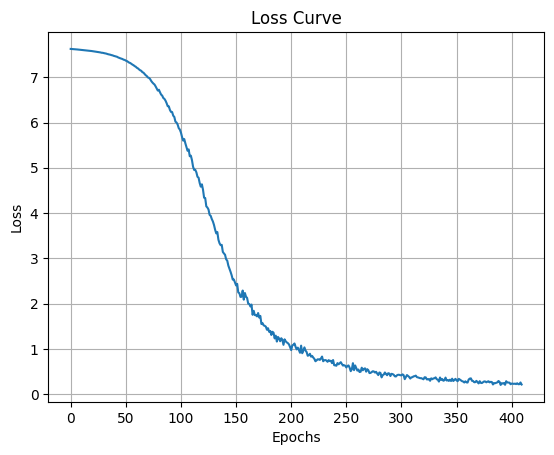

In [26]:
plt.plot(loss_history)
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

Note that this is our **training set** loss.

In [27]:
loss_history[-5:]

[0.2415381819009781,
 0.2201191931962967,
 0.22158516943454742,
 0.25895166397094727,
 0.21453702449798584]

### 2.1 Brute force proof

Let's start proving things now! One thing we can do is a brute force proof. Remember that our proofs will consist of two steps. The first step (P1) is as follows

Theorem(Brute force proof):
The expected loss of a model $M$ with weights $\theta$ is bounded above by $\mathbb{E}[f(t_1,t_2)]$.

Proof: By definition the bound is actually an equality.

That was an easy proof, but the ones we will encounter from now on will be more difficult and feel less tautological!
Now we come to the second part of the proof (P2), which in this case means computing this quantity.

In [28]:
performance = []

In [29]:
def brute_force_loss(model, params: Parameters) -> Float:
    """Computes the loss for every possible input and returns the average of the sum of the losses"""

    loss = 0
    criterion = t.nn.CrossEntropyLoss()

    # Solution goes here

    pass

In [30]:
@measure_time
def brute_force_loss_proof(model, params):
    loss = 0
    criterion = t.nn.CrossEntropyLoss()

    with t.no_grad():
        model.eval()

        for x in tqdm(range(0, params.d_vocab)):

            x_tensor = t.tensor([x] * (params.d_vocab))
            y_tensor = t.tensor([i for i in range(params.d_vocab)])

            labels = t.max(x_tensor, y_tensor)

            inputs = t.stack(
                [
                    F.one_hot(x_tensor, num_classes=params.d_vocab).float(),
                    F.one_hot(y_tensor, num_classes=params.d_vocab).float(),
                ],
                dim=1,
            )

            outputs = model(inputs)

            loss += criterion(outputs, labels)

    return loss / params.d_vocab

In [31]:
loss_bf, time_bf = brute_force_loss_proof(model=model, params=params)

100%|██████████| 2048/2048 [01:36<00:00, 21.31it/s]

Function 'brute_force_loss_proof' executed in: 96.096797 seconds


In [32]:
performance.append((loss_bf, time_bf))

<details>
  <summary>A word on the "formal" in "formal proofs"</summary>
  
  Strictly speaking we would want to formalize our proofs, meaning that we would rewrite them in a form that can be verified by a formal proof assistant such as Lean or Coq. For a more serious use case this would be indeed necessary, but for now I will leave it open to the you, the reader, to formalize the proof that you would want to be verified. Generally speaking, be aware though that Lean and Coq also have bugs!
  
</details>

### 2.2 Symmetry proof

Our brute force proof gave the optimal bound, but at the cost of having to compute all the inputs. 
Can we do better? Yes!

We start with the first part P1 of our proof. It will be based on the following observation

Lemma: Let $f_\theta(t_1,t_2)$ denote the neural network as depicted above. Then $$ f_\theta(t_1,t_2) = f_\theta(t_2,t_1).$$

Try to prove that statement!

<details>
  <summary>Proof</summary>
  
  This is a consequence of the following equalities 
  $$f_\theta(t_1,t_2)= g_\theta(t_1.E+t_2.E)= g_\theta(t_2.E+t_1.E)=f_\theta(t_1,t_2).$$
  
</details>

Now you can use that statement to prove the following statement.

Theorem: The expected loss of a model M with weights $\theta$ is bounded by (and in fact equal to) $$\frac{1}{d_{vocab}^2} \cdot \big[ \sum_{t_1<t_2} 2\cdot f_\theta(t_1,t_2) + \sum_{t_1} f_\theta(t_1,t_1) \big].$$

<details>
  <summary>Proof</summary>
  
  This is a consequence of the following equality
  $$\sum_{t_1,t_2}  f_\theta(t_1,t_2)= \sum_{t_1<t_2} f_\theta(t_1,t_2) + \sum_{t_1} f_\theta(t_1,t_1) + \sum_{t_1>t_2} f_\theta(t_1,t_2) = \sum_{t_1<t_2} f_\theta(t_1,t_2) + \sum_{t_1} f_\theta(t_1,t_1) + \sum_{t_2<t_1} f_\theta(t_2,t_1) = \sum_{t_1<t_2} 2\cdot f_\theta(t_1,t_2) + \sum_{t_1} f_\theta(t_1,t_1).$$
  
</details>

Now we can come to the second part P2 of our proof -- actually computing the quantity.

In [33]:
def symmetry_proof_loss(model, params: Parameters) -> Float:
    """Computes the loss for the inputs specified above and returns the average of the sum of the losses (weighted correctly)"""

    loss = 0
    criterion = t.nn.CrossEntropyLoss()

    # Solution goes here

    pass

In [36]:
@measure_time
def symmetry_proof_loss(model, params):
    loss = 0
    criterion = t.nn.CrossEntropyLoss()

    with t.no_grad():
        model.eval()
        for x in tqdm(range(0, params.d_vocab - 1)):

            x_tensor = t.tensor([x] * (params.d_vocab - x - 1))
            y_tensor = t.tensor([x + i + 1 for i in range(params.d_vocab - x - 1)])

            labels = t.max(x_tensor, y_tensor)
            inputs = t.stack(
                [
                    F.one_hot(x_tensor, num_classes=params.d_vocab).float(),
                    F.one_hot(y_tensor, num_classes=params.d_vocab).float(),
                ],
                dim=1,
            )

            outputs = model(inputs)

            loss += criterion(outputs, labels) * 2 * len(x_tensor)

        x_tensor = t.eye(params.d_vocab)
        inputs = t.stack([x_tensor] * 2, dim=1)

        outputs = model(inputs)

        loss += criterion(outputs, t.tensor([i for i in range(params.d_vocab)])) * len(
            x_tensor
        )

    return loss / (params.d_vocab * params.d_vocab)

In [37]:
loss_sym, time_sym = symmetry_proof_loss(model=model, params=params)

100%|██████████| 2047/2047 [00:46<00:00, 44.12it/s] 


Function 'symmetry_proof_loss' executed in: 46.451175 seconds


In [38]:
performance.append((loss_sym, time_sym))

### 2.3 Convexity proof

So far our proofs didn't involve any proper bounds. We will now start using more coarse bounds, but this will lead to a great increase in compression. The central notion for this section is **convexity**.

Definition:
- A function $f:\mathbb{R}^n\to \mathbb{R}$ is convex, if $\forall x,y\in \mathbb{R}^n$ and $t\in [0,1]$, we have an inequality
$$ f(tx+(1-t)y)\leq tf(x)+(1-t)f(y).$$
- A function $f:\mathbb{R}^n\to \mathbb{R}^m$ is convex, if all the projections $f_1,...,f_m: \mathbb{R}^n\to \mathbb{R}^m\xrightarrow{pr_i} \mathbb{R}$ are convex.

Our strategy in this section is:
1. Prove that $L\circ g_\theta(v)$ is convex
2. Use that to prove a bound for $f_\theta(t_1,t_2)$
3. Compute the bound concretely

Again, step 1 and 2 are the P1 part of our proof and step 3 is the P2 part of our proof.

#### 1. Proving that $L \circ g_{\theta}(v)$ is convex:

First we prove this general statement:

Lemma: Let $f_1:\mathbb{R}^n\to \mathbb{R}^m$ and $ f_2: \mathbb{R}^m\to \mathbb{R}^k$ be a linear and a convex function respectively, then $f_2\circ f_1: \mathbb{R}^n\to \mathbb{R}^k$ is convex as well.

<details>
  <summary>Proof</summary>
  This follows from the following inequalities

  $$f_2(f_1(t\cdot x + (1-t)\cdot y))=f_2(t\cdot f_1(x) + (1-t)\cdot f_1(y))\leq t\cdot f_2(f_1(x)) + (1-t)\cdot f_2(f_1(y)) $$
  where the first equality follows from linearity of $f_1$ and the second one from convexity of $f_2$.
  
</details>

Now we will combine the above statement with the following lemma.

Lemma: $g_\theta(v)$ is linear and $L(-,x)$ is convex.

<details>
  <summary>Proof</summary>

- $g_\theta(v)$ is a composition of linear functions, therefore also linear.

- There are several ways to prove that $L$ is convex. One could verify that the Hessian of $L$ is positive semi-definite or directly apply the Hölderlin inequality. Let's use the latter approach.
Our goal is to show that for $x\in \mathbb{R}^m$ we have the following function is convex
$$  -log(\frac{e^{x_i}}{\sum^m_{j=1}e^{x_j}}) $$
where we fixed an $i\in \{1,...,m\}$ (corresponding to the correct label).
We can rewrite the function as
$$ - x_i + log(\sum^m_{j=1}e^{x_j})$$
and it suffices to show that $log(\sum^m_{j=1}e^{x_j})$ is convex. This follows from the Hölderlin inequality
$$ \sum e^{t\cdot x_i} e^{(1-t)\cdot y_i} \leq (\sum e^{ x_i})^t \cdot (\sum e^{ y_i})^{1-t}.$$


</details>

#### 2. Proving a bound for $f_\theta(t_1,t_2)$

Theorem: The expected loss of a model M with weights $\theta$ is bounded above by 
$$\frac{1}{d_{vocab}^2} \cdot \big[ \sum_{t_1} L(g_\theta(t_1,t_1),t_1) + \sum_{t_1<t_2} L(g_\theta(t_1,t_1), t_2) + L(g_\theta(t_2,t_2), t_2) \big].$$

Note that we can rewrite the first and last term as $f_\theta(t_1,t_1)$ and $f_\theta(t_2,t_2)$ respectively, but we can't rewrite the middle term in terms of $f_\theta$ (Why?). 

<details>
  <summary>Proof</summary>

From the symmetric proof section we have seen that expected loss is equal to $\frac{1}{d_{vocab}^2} \cdot \big[  \sum_{t_1} f_\theta(t_1,t_1) + \sum_{t_1<t_2} 2\cdot f_\theta(t_1,t_2) \big]$.

From the previous lemma we have seen, given $t_2>t_1$, that $ f_\theta(t_1,t_2)= L(g_\theta(t_1.E +t_2.E), t_2)\leq \frac{1}{2} \cdot L(g_\theta(2\cdot t_1.E), t_2) + \frac{1}{2} \cdot L(g_\theta(2\cdot t_2.E), t_2) $.

Combining the previous two statements yield the desired statement.
  
</details>

Now we come to the part P2 of our proof -- computing the above quantity.

In [ ]:
def convexity_proof(model, params: Parameters):
    """Computes the loss for the diagonal entries and otherwise the convex bound specified above"""

    loss = 0
    criterion = t.nn.CrossEntropyLoss()

    # Solution goes here

    pass

In [63]:
@measure_time
def convexity_proof(model, params):
    loss = 0

    with t.no_grad():
        model.eval()

        criterion = t.nn.CrossEntropyLoss()

        inputs = t.stack([t.eye(params.d_vocab) * 2], dim=1)

        logits = model(inputs)
        print(logits.shape)

        for i in tqdm(range(1, params.d_vocab)):

            loss += (i + 1) * criterion(logits[: i + 1], t.tensor([i] * (i + 1)))

        loss += params.d_vocab * criterion(
            logits, t.tensor([i for i in range(params.d_vocab)])
        )

    return loss / (params.d_vocab**2)

In [62]:
performance

[(tensor(0.2316), 96.0967972278595),
 (tensor(0.2316), 46.45117521286011),
 (tensor(11.1569), 8.93980884552002),
 (tensor(11.1569), 10.201393842697144),
 (tensor(11.1569), 9.749002933502197),
 (tensor(11.1349), 9.241036176681519)]

In [64]:
performance.append(convexity_proof(model=model, params=params))

torch.Size([2048, 2048])


100%|██████████| 2048/2048 [00:09<00:00, 206.51it/s]

Function 'convexity_proof' executed in: 9.998189 seconds


### 2.4 Summary

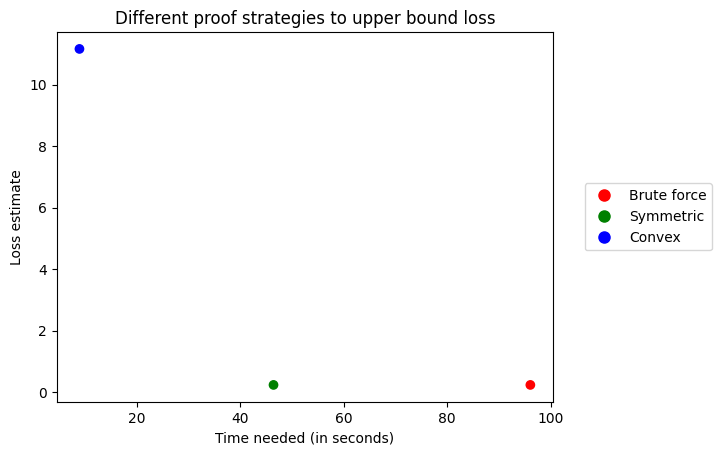

In [55]:
x = [performance[i][1] for i in range(3)]
y = [performance[i][0] for i in range(3)]
labels = ["Brute force", "Symmetric", "Convex"]
colors = ["red", "green", "blue"]


# Create plot
plt.scatter(x, y, c=colors)


for label, color in zip(labels, colors):
    plt.plot([], [], marker="o", linestyle="", markersize=8, color=color, label=label)

plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
plt.title("Different proof strategies to upper bound loss")
plt.xlabel("Time needed (in seconds)")
plt.ylabel("Loss estimate")
plt.show()

Let's break down what we see. On the $x$-axis we have the time it took to run the proofs. This is a proxy for the compactness of the proof. 
Another related notion would be to track the FLOPS needed to run the proof.
We see that the symmetric proof takes about half of the time compared to the brute force one. 
This makes sense: 

There is a total of $d^2$ inputs that the brute force proof needs. On the other hand the symmetric proof needs only $\frac{d(d+1)}{2}$ inputs. But note that our architecture was very simple -- we can't expect such an easy improvement in general. Note also that asymptotically both proofs scale **quadratic** in $d$.

On the other hand the convex proof scales only **linearly** in $d$. This is great, but it comes at a great cost: Our bound is very bad and we find ourselves on the other end of trade off, close to a vacuous proof. In fact, there is a straight forward explanation why our bound will always be comparatively coarse. Can you figure out why?

<details>
  <summary>The reason...</summary>

...that we should expect a very coarse bound in the expression $$ \big[ \sum_{t_1} L(g_\theta(t_1,t_1),t_1) + \sum_{t_1<t_2} L(g_\theta(t_1,t_1), t_2) + L(g_\theta(t_2,t_2), t_2) \big].$$

is the middle term $ L(g_\theta(t_1,t_1), t_2)$. This term computes the cross-entropy loss **not** between $\ell_{[t_1,t_1]}$ and $t_1= max([t_1,t_1])$, but between $\ell_{[t_1,t_1]}$  and $t_2$.
Thus even if our model would perform optimally, this term would remain high.
</details>

This concludes the first example! In the next section, we will explore a slightly different set up, where our convex proof will yield useful results. After that we are ready to dig into the proofs of the paper and replicate some of them. These will turn out to be more difficult, but will also make use of more serious mechanistic machinery. 

## 3. Making convex work for $n=3$

We now slightly change our model and proof a new bound about it. This will be very similar to the previous section, but with better result.

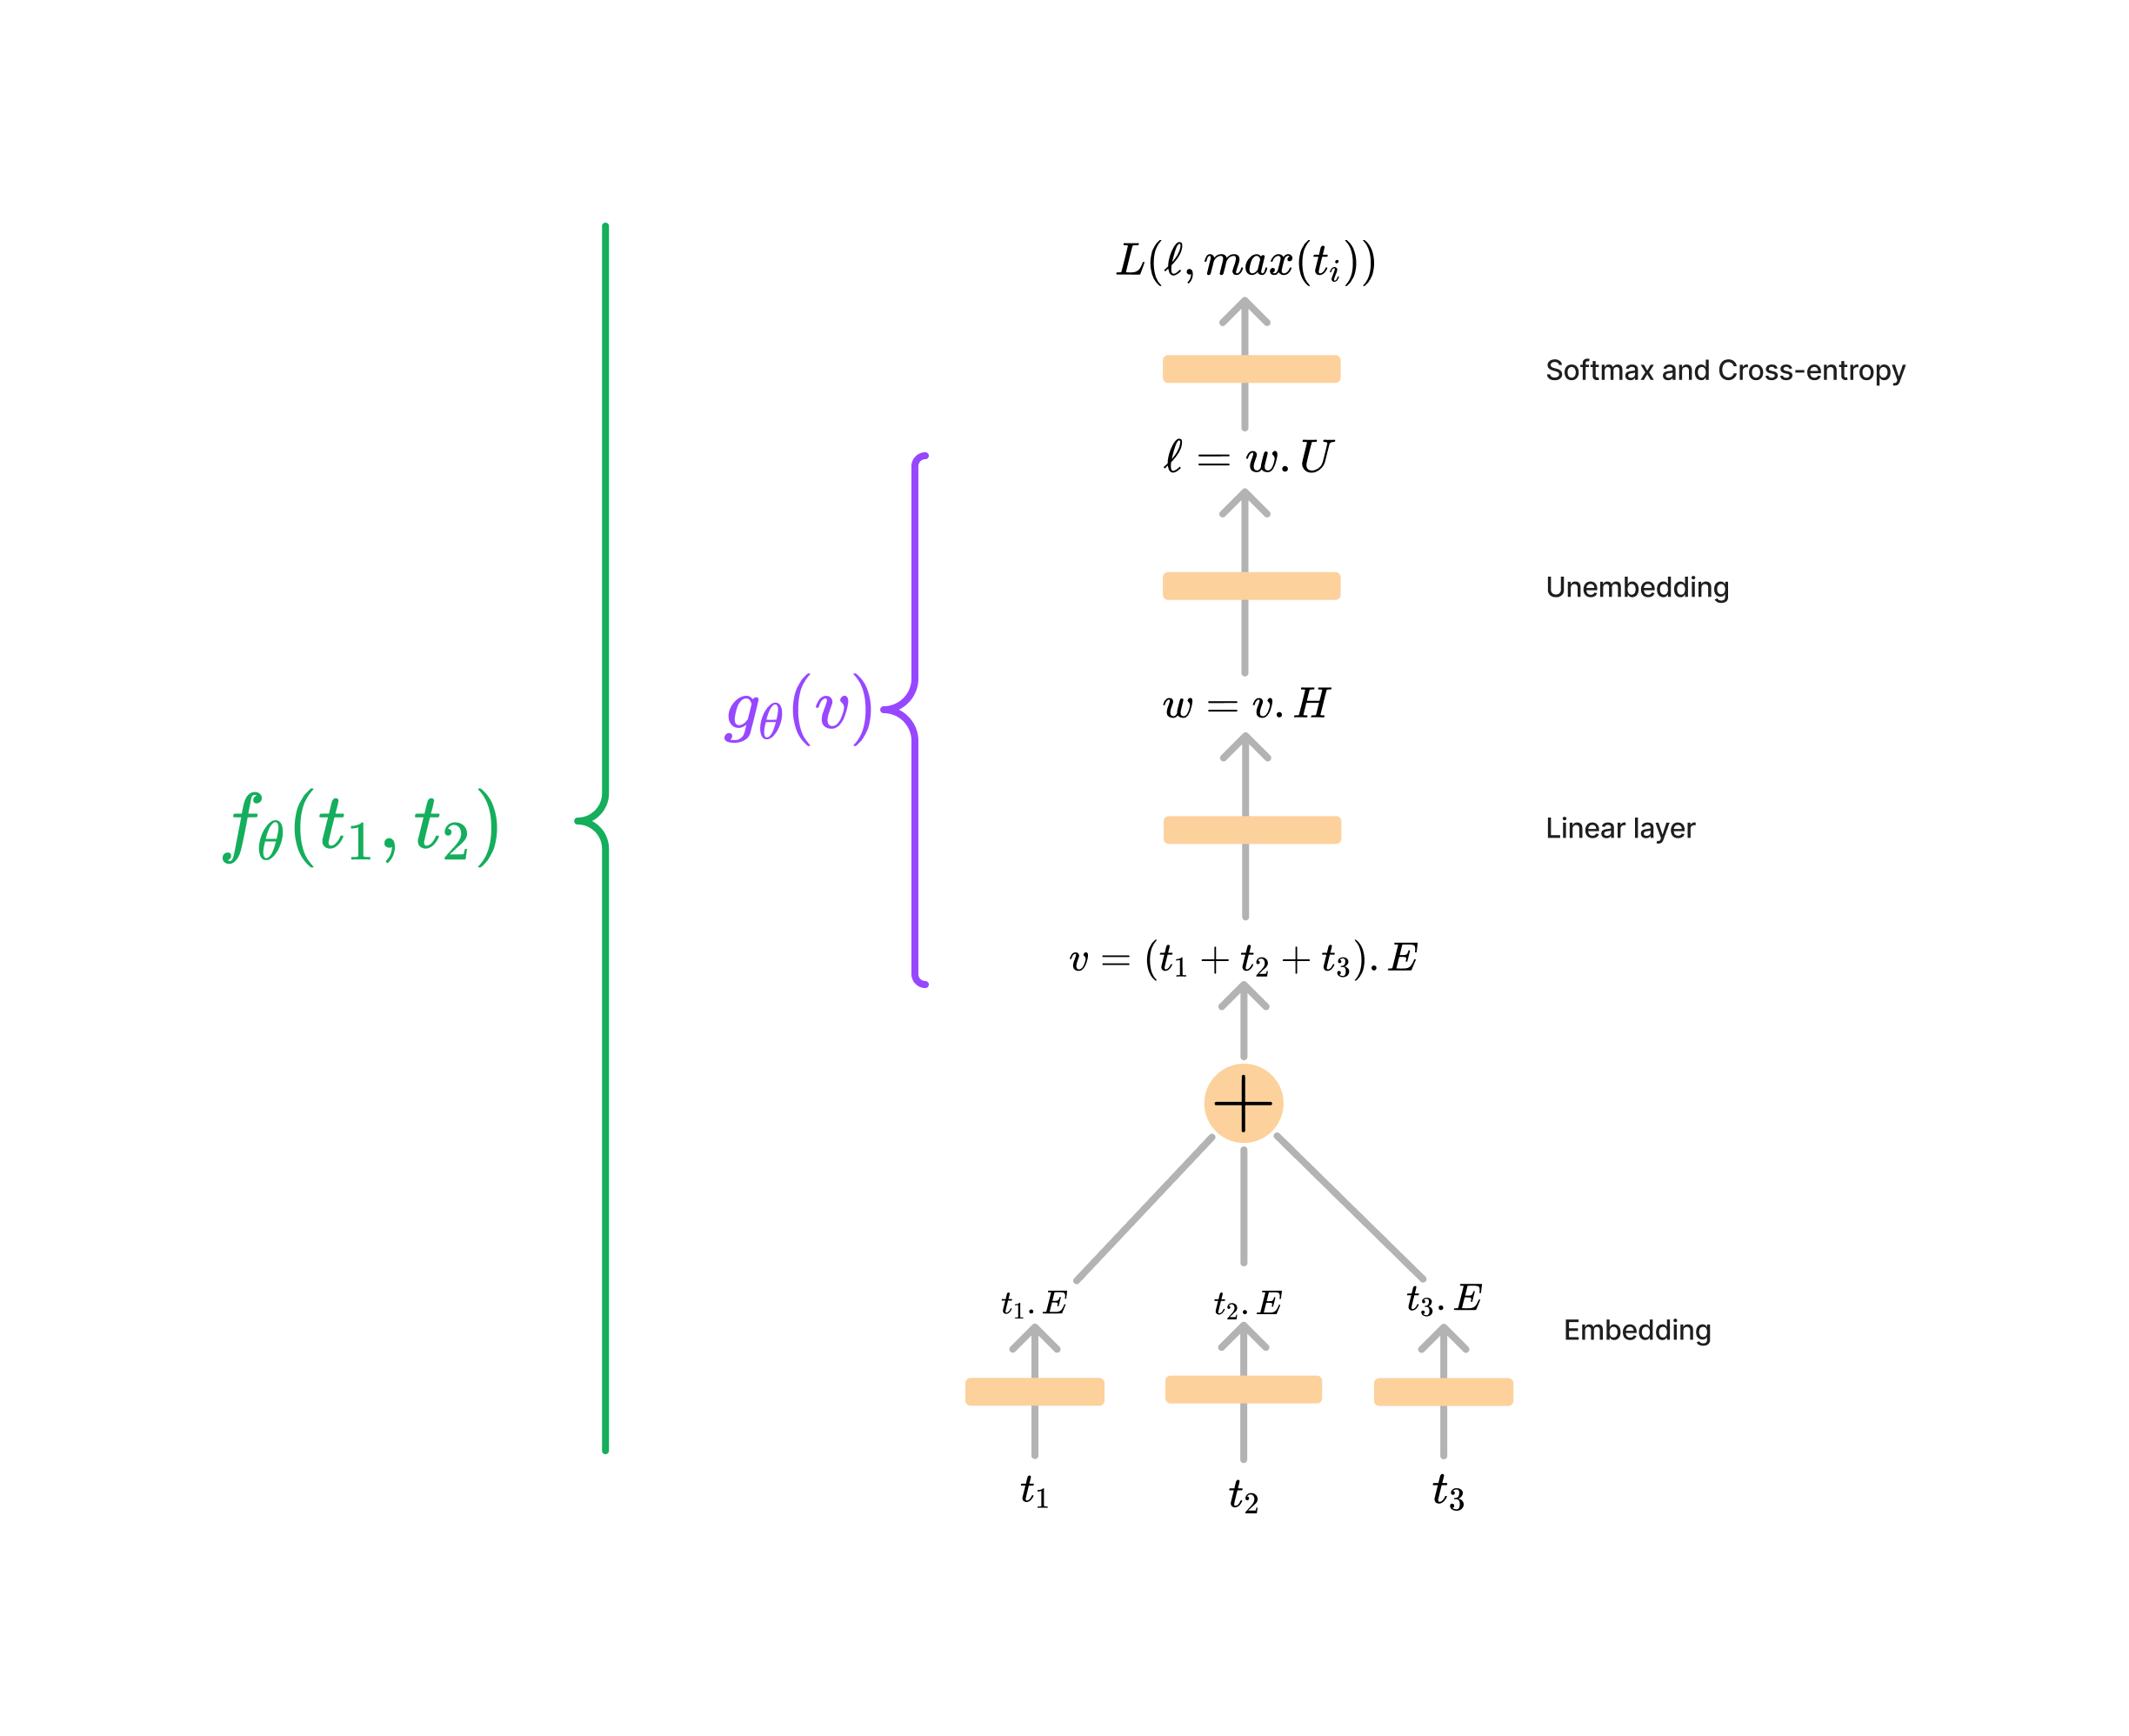

In [68]:
Image("img/Model_3.png", height="700", width="700")

In [69]:
params_3 = Parameters(n_ctx=3, d_vocab=16)  # Set this to 256 later
train_data_3 = TrainingDataMax(params=params_3)
model_3 = MLP(params=params_3)

So now our model is trained to predict the max of 3 tokens.

In [70]:
loss_history_3 = train(model=model_3, params=params_3)

100%|██████████| 2/2 [00:00<00:00,  4.45it/s]


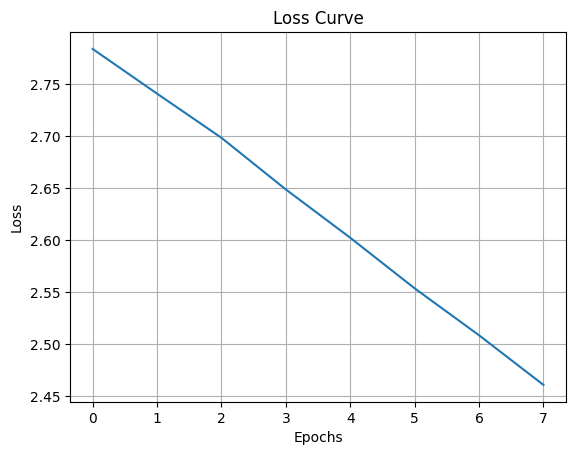

In [71]:
plt.plot(loss_history_3)
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

We can apply the brute force method again, the proof is as before.

In [75]:
@measure_time
def brute_force_loss_proof_3(model, params):
    loss = 0
    criterion = t.nn.CrossEntropyLoss(reduction="sum")

    count = 0

    with t.no_grad():
        model.eval()

        for x in tqdm(range(0, params.d_vocab)):

            x_tensor = t.tensor(
                [i for i in range(params.d_vocab) for _ in range(params.d_vocab)]
            )

            y_tensor = t.tensor(list(range(params.d_vocab)) * params.d_vocab)

            z_tensor = t.tensor([x] * params.d_vocab**2)

            max_xy = t.max(x_tensor, y_tensor)
            labels = t.max(max_xy, z_tensor)

            inputs = t.stack(
                [
                    F.one_hot(x_tensor, num_classes=params.d_vocab).float(),
                    F.one_hot(y_tensor, num_classes=params.d_vocab).float(),
                    F.one_hot(z_tensor, num_classes=params.d_vocab).float(),
                ],
                dim=1,
            )

            outputs = model(inputs)

            loss += criterion(outputs, labels)

    return loss / params.d_vocab**3

In [76]:
brute_force_loss_proof_3(model=model_3, params=params_3)[0]

100%|██████████| 16/16 [00:00<00:00, 750.78it/s]

Function 'brute_force_loss_proof_3' executed in: 0.025584 seconds


tensor(2.4179)

#### 1. Proving a bound for $f_\theta(t_1,t_2,t_3)$

Now we come to the P1 part of our proof. Again we make use of the convexity.


Theorem: The expected loss of a model M with weights $\theta$ is bounded above by 
$$\frac{1}{d_{vocab}^2} \cdot \big[ \sum_{t_1} L(g_\theta(t_1,t_1),t_1) + \sum_{t_1<t_2} L(g_\theta(t_1,t_1), t_2) + L(g_\theta(t_2,t_2), t_2) \big].$$

Note that we can rewrite the first and last term as $f_\theta(t_1,t_1)$ and $f_\theta(t_2,t_2)$ respectively, but we can't rewrite the middle term in terms of $f_\theta$ (Why?). 



In [46]:
def convexity_proof_three_equal(
    model,
    params: Parameters,
):

    loss = 0
    criterion = t.nn.CrossEntropyLoss(reduction="sum")

    with t.no_grad():

        # Estimate f(x,x,x)

        x_one_hot = t.eye(params.d_vocab)

        inputs = t.stack([x_one_hot] * 3, dim=1)
        outputs = model(inputs)

        loss += criterion(outputs, t.tensor([i for i in range(params.d_vocab)]))

    return loss

In [47]:
def convexity_proof_two_equal(model, params: Parameters):

    loss = 0
    criterion = t.nn.CrossEntropyLoss(reduction="sum")

    with t.no_grad():
        # Estimate f(x,x,z) where x<z
        for z in range(1, params.d_vocab):

            # [0,1,...,z-1]
            x_tensor = t.tensor([i for i in range(z)])
            # [z,z,...,z]
            z_tensor = t.tensor([z] * z)

            inputs = t.stack(
                [
                    F.one_hot(x_tensor, num_classes=params.d_vocab).float(),
                    F.one_hot(x_tensor, num_classes=params.d_vocab).float(),
                    F.one_hot(z_tensor, num_classes=params.d_vocab).float(),
                ],
                dim=1,
            )
            outputs = model(inputs)

            loss += 3 * criterion(outputs, z_tensor)

        # Estimate f(x,z,z) where x<z
        for z in range(1, params.d_vocab):

            # [0,1,...,z-1]
            x_tensor = t.tensor([i for i in range(z)])
            # [z,z,...,z]
            z_tensor = t.tensor([z] * z)

            inputs = t.stack(
                [
                    F.one_hot(x_tensor, num_classes=params.d_vocab).float(),
                    F.one_hot(z_tensor, num_classes=params.d_vocab).float(),
                    F.one_hot(z_tensor, num_classes=params.d_vocab).float(),
                ],
                dim=1,
            )
            outputs = model(inputs)

            loss += 3 * criterion(outputs, z_tensor)

    return loss

In [61]:
def convexity_proof(model, params: Parameters):

    loss = []
    criterion = t.nn.CrossEntropyLoss(reduction="sum")

    with t.no_grad():
        # Estimate f(x,y,z) where x<y<z

        def estimate_fixed(z: int):
            count = 0

            # [0,1,...,z-1]
            x_tensor = t.tensor([i for i in range(z)])

            length = x_tensor.size(dim=0)

            # [z,z,...,z]
            z_tensor = t.tensor([z] * length)

            inputs = t.stack(
                [
                    F.one_hot(x_tensor, num_classes=params.d_vocab).float(),
                    F.one_hot(x_tensor, num_classes=params.d_vocab).float(),
                    F.one_hot(z_tensor, num_classes=params.d_vocab).float(),
                ],
                dim=1,
            )

            outputs = model(inputs)

            count = (length - 1) * criterion(outputs, z_tensor)
            # This should be 3
            return 3 * count

        for z in tqdm(range(2, params.d_vocab)):
            loss.append(estimate_fixed(z))

    loss.append(convexity_proof_three_equal(model=model, params=params))

    loss.append(convexity_proof_two_equal(model=model, params=params))

    return loss

In [59]:
x = convexity_proof(model=model_3, params=params_3)

100%|██████████| 14/14 [00:00<00:00, 1018.92it/s]


## 4. Implementing the cubic proof